<a href="https://colab.research.google.com/github/vladimiralencar/DeepLearning-LANA/blob/master/LSTM/Previsoes_Series_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Previsões com Séries Temporais e RNNs 

## Carregando os Dados

Primeiro, devemos carregar nossas séries temporais - uma série histórica de cerca de 140 dias do preço das ações da Apple (extraído do site DataMarket - https://datamarket.com/data/list/?q=provider%3Atsdl). Em seguida, precisamos executar uma série de etapas de pré-processamento para preparar os dados para uso com um modelo RNN. 

É uma boa prática normalizar as séries temporais - normalizando seu range. Isso nos ajuda a evitar problemas numéricos sérios associados a funções de ativação comuns (como o tanh) que transformam números muito grandes (positivos ou negativos), além de ajudar a evitar problemas relacionados ao computar derivadas.

Aqui nós normalizamos a série para ficar na faixa [0,1], mas é também é comum normalizar por um desvio padrão da série.

In [0]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


In [0]:
dataset = np.loadtxt('datasets/normalized_apple_prices.csv')

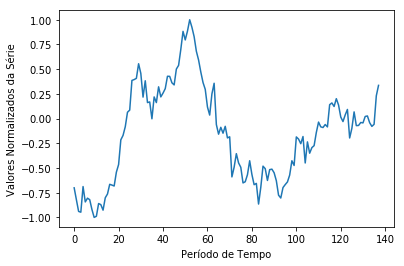

In [0]:
# Plot
plt.plot(dataset)
plt.xlabel('Período de Tempo')
plt.ylabel('Valores Normalizados da Série')

## Extraindo Sequências da Série Temporal

Lembre-se, nossa série de tempo é uma sequência de números que podemos representar em termos matemáticos, como:

$$s_{0},s_{1},s_{2},...,s_{P}$$

onde $ s_ {p} $ é o valor numérico das séries temporais no período de tempo $ p $ e onde $ P $ é o comprimento total da série. Para aplicar nossa RNN tratamos o problema de previsão de séries temporais como um problema de regressão e, portanto, precisamos usar uma janela deslizante para construir um conjunto de pares de entrada / saída associados para regredir. Este processo é representado no gif abaixo.

<img src="images/timeseries_windowing_training.gif" width=600 height=600/>

Por exemplo - usando uma janela de tamanho T = 5 (como ilustrado no gif acima) produzimos um conjunto de pares de entrada / saída como o mostrado na tabela abaixo

$$
\begin{array}{c|c}
\text{Input} & \text{Output}\\
\hline \color{CornflowerBlue} {\langle s_{1},s_{2},s_{3},s_{4},s_{5}\rangle} & \color{Goldenrod}{ s_{6}} \\
\ \color{CornflowerBlue} {\langle s_{2},s_{3},s_{4},s_{5},s_{6} \rangle } & \color{Goldenrod} {s_{7} } \\
\color{CornflowerBlue}  {\vdots} & \color{Goldenrod} {\vdots}\\
\color{CornflowerBlue} { \langle s_{P-5},s_{P-4},s_{P-3},s_{P-2},s_{P-1} \rangle } & \color{Goldenrod} {s_{P}}
\end{array}$$

Observe aqui que cada entrada é uma sequência (ou vetor) de comprimento 4 (e em geral tem um comprimento igual ao tamanho da janela T), enquanto cada saída correspondente é um valor escalar. Observe também como é dada uma série de tempo de comprimento P e tamanho de janela T = 5 como mostrado acima, criamos pares de entrada / saída P-5. De forma mais geral, para um tamanho de janela T, criamos P-T desses pares.

Abaixo, temos uma função que cria essa janela deslizante.

In [0]:
# Função que transforma séries e window-size em um conjunto de input/output para o modelo RNN 
def window_transform_series(series, window_size):
    """
      Argumentos:
        series(np.array(list)): Sequência de valores
        window_size(int      ): Tamanho da janela
      
      Retorna:
         X(np.array(list(list))): Matriz de Input
         y(np.array(list))      : Array de Ouput
    """

    # Objetos para input/output 
    X = np.asarray([series[i:(i + window_size)] for i in range(len(series) - window_size)])
    y = np.asarray([series[i + window_size] for i in range(len(series) - window_size)])

    return X,y

Aplicamos a função ao nosso conjunto de dados e definimos um windows-size = 7.

In [0]:
window_size = 7
X,y = window_transform_series(series = dataset, window_size = window_size)

In [0]:
X.shape

(131, 7)

In [0]:
X

array([[-0.70062339, -0.82088484, -0.93938305, -0.9471652 , -0.68785527,
        -0.84325902, -0.80532018],
       [-0.82088484, -0.93938305, -0.9471652 , -0.68785527, -0.84325902,
        -0.80532018, -0.82058073],
       [-0.93938305, -0.9471652 , -0.68785527, -0.84325902, -0.80532018,
        -0.82058073, -0.92023124],
       [-0.9471652 , -0.68785527, -0.84325902, -0.80532018, -0.82058073,
        -0.92023124, -1.        ],
       [-0.68785527, -0.84325902, -0.80532018, -0.82058073, -0.92023124,
        -1.        , -0.98814438],
       [-0.84325902, -0.80532018, -0.82058073, -0.92023124, -1.        ,
        -0.98814438, -0.85961411],
       [-0.80532018, -0.82058073, -0.92023124, -1.        , -0.98814438,
        -0.85961411, -0.8706188 ],
       [-0.82058073, -0.92023124, -1.        , -0.98814438, -0.85961411,
        -0.8706188 , -0.92661512],
       [-0.92023124, -1.        , -0.98814438, -0.85961411, -0.8706188 ,
        -0.92661512, -0.80118585],
       [-1.        , -0.9881

## Dados de Treino e de Teste

Para realizar testes adequados em nosso conjunto de dados, usaremos o último 1/3 dele para teste. Isto é, uma vez que treinamos nosso modelo, temos algo para testá-lo (como qualquer problema de regressão!). Esta divisão em conjuntos de treinamento/teste é feita na célula abaixo.

Observe como aqui ** não ** estamos dividindo o conjunto de dados * aleatoriamente * como normalmente seria feito ao validar um modelo de regressão. Isso ocorre porque nossos pares de entrada/saída * estão relacionados temporariamente *. Não queremos validar o nosso modelo treinando em um subconjunto aleatório da série e depois testar em outro subconjunto aleatório.

Queremos treinar em um pedaço sólido da série (no nosso caso, os primeiros 2/3 completos), e validar em um pedaço posterior (o último 1/3), pois isso simula como prevermos os valores do * futuro * de uma série temporal.

In [0]:
# Split em treino e teste
train_test_split = int(np.ceil(2*len(y)/float(3)))  # Ponto de spplit

# Particiona os dados de treino em X e Y
X_train = X[:train_test_split,:]
y_train = y[:train_test_split]

# Particiona os dados de teste em X e Y
X_test = X[train_test_split:,:]
y_test = y[train_test_split:]

# Para criar o Modelo RNN LSTM com o Keras nossos dados precisam estar no formato [samples, window size, stepsize] 
X_train = np.asarray(np.reshape(X_train, (X_train.shape[0], window_size, 1)))
X_test = np.asarray(np.reshape(X_test, (X_test.shape[0], window_size, 1)))

In [0]:
X_train.shape

(88, 7, 1)

In [0]:
print(X_train)

[[[-0.70062339]
  [-0.82088484]
  [-0.93938305]
  [-0.9471652 ]
  [-0.68785527]
  [-0.84325902]
  [-0.80532018]]

 [[-0.82088484]
  [-0.93938305]
  [-0.9471652 ]
  [-0.68785527]
  [-0.84325902]
  [-0.80532018]
  [-0.82058073]]

 [[-0.93938305]
  [-0.9471652 ]
  [-0.68785527]
  [-0.84325902]
  [-0.80532018]
  [-0.82058073]
  [-0.92023124]]

 [[-0.9471652 ]
  [-0.68785527]
  [-0.84325902]
  [-0.80532018]
  [-0.82058073]
  [-0.92023124]
  [-1.        ]]

 [[-0.68785527]
  [-0.84325902]
  [-0.80532018]
  [-0.82058073]
  [-0.92023124]
  [-1.        ]
  [-0.98814438]]

 [[-0.84325902]
  [-0.80532018]
  [-0.82058073]
  [-0.92023124]
  [-1.        ]
  [-0.98814438]
  [-0.85961411]]

 [[-0.80532018]
  [-0.82058073]
  [-0.92023124]
  [-1.        ]
  [-0.98814438]
  [-0.85961411]
  [-0.8706188 ]]

 [[-0.82058073]
  [-0.92023124]
  [-1.        ]
  [-0.98814438]
  [-0.85961411]
  [-0.8706188 ]
  [-0.92661512]]

 [[-0.92023124]
  [-1.        ]
  [-0.98814438]
  [-0.85961411]
  [-0.8706188 ]
  [-0.92

## Construindo o Modelo RNN

Tendo criado pares de entrada / saída de nossas séries temporais e dividido em conjuntos de treinamento / teste, agora podemos começar a configurar nossa RNN. Usamos o Keras para criar rapidamente uma RNN de duas camadas ocultas com as  seguintes especificações

- A camada 1 usa um módulo LSTM com 5 unidades escondidas (observe aqui o input_shape = (window_size, 1))
- A camada 2 usa um módulo totalmente conectado com uma unidade
- A perda 'mean_squared_error' deve ser usada (lembre-se: estamos realizando regressão aqui)

In [0]:
# RNN para regressão em nossos dados de séries temporais 
def build_RNN(window_size):
    model = Sequential()
    model.add(LSTM(5, input_shape=(window_size,1)))
    model.add(Dense(1))
    return model

In [0]:
# Cria e compila o modelo
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

# Random seed
np.random.seed(0)

# Build do modelo
model = build_RNN(window_size)

# Otimizador
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

# Compila o modelo
model.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


Fit do modelo

In [0]:
model.fit(X_train, y_train, epochs = 1000, batch_size = 50, verbose = 1)

Epoch 1/1000
88/88 [==============================] - 1s - loss: 0.1422     
Epoch 2/1000
88/88 [==============================] - 0s - loss: 0.1343     
Epoch 3/1000
88/88 [==============================] - 0s - loss: 0.1290     
Epoch 4/1000
88/88 [==============================] - 0s - loss: 0.1245     
Epoch 5/1000
88/88 [==============================] - 0s - loss: 0.1205     
Epoch 6/1000
88/88 [==============================] - 0s - loss: 0.1169     
Epoch 7/1000
88/88 [==============================] - 0s - loss: 0.1138     
Epoch 8/1000
88/88 [==============================] - 0s - loss: 0.1106     
Epoch 9/1000
88/88 [==============================] - 0s - loss: 0.1079     
Epoch 10/1000
88/88 [==============================] - 0s - loss: 0.1051     
Epoch 11/1000
88/88 [==============================] - 0s - loss: 0.1021     
Epoch 12/1000
88/88 [==============================] - 0s - loss: 0.0994     
Epoch 13/1000
88/88 [==============================] - 0s - loss: 0.0967 

88/88 [==============================] - 0s - loss: 0.0355     
Epoch 107/1000
88/88 [==============================] - 0s - loss: 0.0354     
Epoch 108/1000
88/88 [==============================] - 0s - loss: 0.0352     
Epoch 109/1000
88/88 [==============================] - 0s - loss: 0.0350     
Epoch 110/1000
88/88 [==============================] - 0s - loss: 0.0350     
Epoch 111/1000
88/88 [==============================] - 0s - loss: 0.0346     
Epoch 112/1000
88/88 [==============================] - 0s - loss: 0.0345     
Epoch 113/1000
88/88 [==============================] - 0s - loss: 0.0343     
Epoch 114/1000
88/88 [==============================] - 0s - loss: 0.0341     
Epoch 115/1000
88/88 [==============================] - 0s - loss: 0.0342     
Epoch 116/1000
88/88 [==============================] - 0s - loss: 0.0339     
Epoch 117/1000
88/88 [==============================] - 0s - loss: 0.0338     
Epoch 118/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0222     
Epoch 210/1000
88/88 [==============================] - 0s - loss: 0.0223     
Epoch 211/1000
88/88 [==============================] - 0s - loss: 0.0221     
Epoch 212/1000
88/88 [==============================] - 0s - loss: 0.0219     
Epoch 213/1000
88/88 [==============================] - 0s - loss: 0.0220     
Epoch 214/1000
88/88 [==============================] - 0s - loss: 0.0217     
Epoch 215/1000
88/88 [==============================] - 0s - loss: 0.0219     
Epoch 216/1000
88/88 [==============================] - 0s - loss: 0.0216     
Epoch 217/1000
88/88 [==============================] - 0s - loss: 0.0216     
Epoch 218/1000
88/88 [==============================] - 0s - loss: 0.0217     
Epoch 219/1000
88/88 [==============================] - 0s - loss: 0.0215     
Epoch 220/1000
88/88 [==============================] - 0s - loss: 0.0213     
Epoch 221/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0176     
Epoch 313/1000
88/88 [==============================] - 0s - loss: 0.0176     
Epoch 314/1000
88/88 [==============================] - 0s - loss: 0.0175     
Epoch 315/1000
88/88 [==============================] - 0s - loss: 0.0176     
Epoch 316/1000
88/88 [==============================] - 0s - loss: 0.0175     
Epoch 317/1000
88/88 [==============================] - 0s - loss: 0.0178     
Epoch 318/1000
88/88 [==============================] - 0s - loss: 0.0175     
Epoch 319/1000
88/88 [==============================] - 0s - loss: 0.0175     
Epoch 320/1000
88/88 [==============================] - 0s - loss: 0.0177     
Epoch 321/1000
88/88 [==============================] - 0s - loss: 0.0177     
Epoch 322/1000
88/88 [==============================] - 0s - loss: 0.0175     
Epoch 323/1000
88/88 [==============================] - 0s - loss: 0.0175     
Epoch 324/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0169     
Epoch 416/1000
88/88 [==============================] - 0s - loss: 0.0171     
Epoch 417/1000
88/88 [==============================] - 0s - loss: 0.0170     
Epoch 418/1000
88/88 [==============================] - 0s - loss: 0.0173     
Epoch 419/1000
88/88 [==============================] - 0s - loss: 0.0170     
Epoch 420/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 421/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 422/1000
88/88 [==============================] - 0s - loss: 0.0170     
Epoch 423/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 424/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 425/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 426/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 427/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0167     
Epoch 519/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 520/1000
88/88 [==============================] - 0s - loss: 0.0167     
Epoch 521/1000
88/88 [==============================] - 0s - loss: 0.0170     
Epoch 522/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 523/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 524/1000
88/88 [==============================] - 0s - loss: 0.0167     
Epoch 525/1000
88/88 [==============================] - 0s - loss: 0.0167     
Epoch 526/1000
88/88 [==============================] - 0s - loss: 0.0167     
Epoch 527/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 528/1000
88/88 [==============================] - 0s - loss: 0.0167     
Epoch 529/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 530/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0165     
Epoch 622/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 623/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 624/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 625/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 626/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 627/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 628/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 629/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 630/1000
88/88 [==============================] - 0s - loss: 0.0169     
Epoch 631/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 632/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 633/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0169     
Epoch 725/1000
88/88 [==============================] - 0s - loss: 0.0164     
Epoch 726/1000
88/88 [==============================] - 0s - loss: 0.0163     
Epoch 727/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 728/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 729/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 730/1000
88/88 [==============================] - 0s - loss: 0.0163     
Epoch 731/1000
88/88 [==============================] - 0s - loss: 0.0163     
Epoch 732/1000
88/88 [==============================] - 0s - loss: 0.0163     
Epoch 733/1000
88/88 [==============================] - 0s - loss: 0.0164     
Epoch 734/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 735/1000
88/88 [==============================] - 0s - loss: 0.0163     
Epoch 736/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0164     
Epoch 828/1000
88/88 [==============================] - 0s - loss: 0.0164     
Epoch 829/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 830/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 831/1000
88/88 [==============================] - 0s - loss: 0.0163     
Epoch 832/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 833/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 834/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 835/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 836/1000
88/88 [==============================] - 0s - loss: 0.0165     
Epoch 837/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 838/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 839/1000
88/88 [==============================] - 0s - loss: 

88/88 [==============================] - 0s - loss: 0.0161     
Epoch 931/1000
88/88 [==============================] - 0s - loss: 0.0160     
Epoch 932/1000
88/88 [==============================] - 0s - loss: 0.0161     
Epoch 933/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 934/1000
88/88 [==============================] - 0s - loss: 0.0161     
Epoch 935/1000
88/88 [==============================] - 0s - loss: 0.0161     
Epoch 936/1000
88/88 [==============================] - 0s - loss: 0.0164     
Epoch 937/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 938/1000
88/88 [==============================] - 0s - loss: 0.0161     
Epoch 939/1000
88/88 [==============================] - 0s - loss: 0.0162     
Epoch 940/1000
88/88 [==============================] - 0s - loss: 0.0166     
Epoch 941/1000
88/88 [==============================] - 0s - loss: 0.0161     
Epoch 942/1000
88/88 [==============================] - 0s - loss: 

In [0]:
X_train.shape

(88, 7, 1)

In [0]:
# Salva o modelo
model.save('lstm_model.h5')

## Avalia a Performance do Modelo

In [0]:
# Gerando previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [0]:
# Print dos erros de treino e de teste
training_error = model.evaluate(X_train, y_train, verbose=0)
print('Erro em Treinamento = %.3f %%' % training_error)

testing_error = model.evaluate(X_test, y_test, verbose=0)
print('Erro em Teste = %.3f %%' %  testing_error)

Erro em Treinamento = 0.016 %
Erro em Teste = 0.014 %


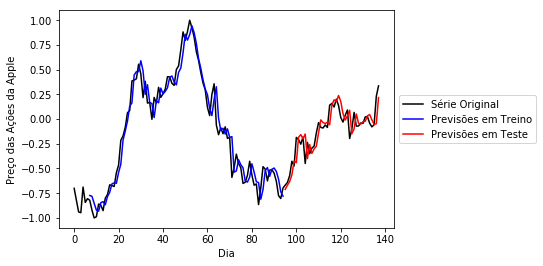

In [0]:
# Plot
import matplotlib.pyplot as plt
%matplotlib inline

# Plot da série original
plt.plot(dataset,color = 'k')

# Plot das previsões em treino
split_pt = train_test_split + window_size 
plt.plot(np.arange(window_size,split_pt,1),train_predict,color = 'b')

# plot das previsões em treino
plt.plot(np.arange(split_pt,split_pt + len(test_predict),1),test_predict,color = 'r')

# Plot
plt.xlabel('Dia')
plt.ylabel('Preço das Ações da Apple')
plt.legend(['Série Original','Previsões em Treino','Previsões em Teste'], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

## Previsões com Novos Conjuntos de Dados

No arquivo pdf onde você encontrou este Jupyter Notebook, estão descritos o procedimento para aplicar seu modelo criado a novos conjuntos de dados. Tudo que você fez no seu conjunto de dados para realizar o treinamento, deve ser repetido em um novo conjunto de dados que você queira usar para fazer as previsões. Vejamos um exemplo.

In [0]:
# Carregando o modelo treinado. Repare que o nome agora é "modelo" e não mais "model". 
modelo = load_model('lstm_model.h5')

In [0]:
# Aqui está seu novo conjunto de dados. 
# Na verdade pegamos os últimos registros do dataset e queremos prever o próximo item da série.
# Perceba que os dados já estão padronizados, pois foi assim que treinamos nosso modelo.
new_data = [-4.362395529396456695e-02,
            2.155369823552977238e-02,
            2.647844739615612397e-02,
            -4.167795105803762112e-02,
            -7.888723449334911209e-02,
            -5.797255139894330611e-02,
            2.305824869067012450e-01,
            3.360086521611651555e-01]

In [0]:
# Visualizando os novos dados
new_data

[-0.04362395529396457,
 0.021553698235529772,
 0.026478447396156124,
 -0.04167795105803762,
 -0.07888723449334911,
 -0.057972551398943306,
 0.23058248690670125,
 0.33600865216116516]

In [0]:
# Agora aplicamos aos novos dados as mesms transformações aplicadas antes do processo de treinamento.
# Criaremos o objeto new_X para diferenciar do objeto X usado no treinamento
window_size = 7
series = new_data
new_X = np.asarray([series[i:(i + window_size)] for i in range(len(series) - window_size)])

In [0]:
# Shape de new_X (compare com o shape de X no início deste notebook)
new_X.shape

(1, 7)

In [0]:
print(new_X)

[[-0.04362396  0.0215537   0.02647845 -0.04167795 -0.07888723 -0.05797255
   0.23058249]]


In [0]:
# O modelo LSTM espera receber os dados com 3 dimensões e por isso precisamos fazer o reshape.
# Fizemos o mesmo durante o pré-processamento dos dados antes de criar o modelo.
final_X = np.asarray(np.reshape(new_X, (new_X.shape[0], window_size, 1)))

In [0]:
# Shape
final_X.shape

(1, 7, 1)

In [0]:
# Agora fazemos as previsões com nosso modelo usando o novo conjunto de dados
pred = modelo.predict(final_X)

In [0]:
print("Próximo valor na série: ", pred)

Próximo valor na série:  [[ 0.21819378]]


# Fim